In [1]:
import os
import tensorflow as tf
import cv2
import shutil
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn

In [ ]:
#import shutil

#shutil.rmtree('./tumor-datasplited')

In [ ]:
#input_folder = "./tumor-dataset"

#splitfolders.ratio(input_folder, output="tumor-datasplited", seed=42, ratio=(.7,.2,.1), group_prefix=None)


In [2]:
try:
    #shutil.rmtree('./tumor-datasplited/.ipynb_checkpoints')
    shutil.rmtree('./tumor-datasplited/test/.ipynb_checkpoints')
    shutil.rmtree('./tumor-datasplited/train/.ipynb_checkpoints')
    shutil.rmtree('./tumor-datasplited/val/.ipynb_checkpoints')
except:
    pass

In [3]:
train_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',)
traindata = train_data.flow_from_directory(directory="./tumor-datasplited/train",target_size=(224,224), class_mode='categorical')

val_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',)
valdata = val_data.flow_from_directory(directory="./tumor-datasplited/val",target_size=(224,224), class_mode='categorical')

test_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',)
testdata = test_data.flow_from_directory(directory="./tumor-datasplited/test",target_size=(224,224), class_mode='categorical', shuffle=False)

Found 2123 images belonging to 3 classes.
Found 606 images belonging to 3 classes.
Found 318 images belonging to 3 classes.


In [4]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))

for layers in vgg16_model.layers:
    layers.trainable=True

2022-12-06 13:59:30.426167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 13:59:30.441230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 13:59:30.441633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 13:59:30.442804: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
output = vgg16_model.layers[-1].output
vgg_x = Flatten()(output)
vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(inputs=vgg16_model.input, outputs=vgg_x)

In [8]:
model = vgg16_final_model
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-5),metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
checkpoint = ModelCheckpoint("vgg16_2.h5", monitor='val_accuracy', 
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')



In [10]:
batch_size = 32

hist = model.fit_generator(steps_per_epoch=(traindata.n//batch_size),generator=traindata, validation_data= valdata, validation_steps=(valdata.n//batch_size),epochs=100,callbacks=[checkpoint, early])

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-06 14:00:16.814941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-06 14:00:18.339227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-12-06 14:00:18.632122: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 14:00:18.632394: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 14:00:18.632416: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-12-06 14:00:18.632715: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 14:00:18.632758: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


66/66 [==============================] - 45s 543ms/step - loss: 0.8796 - accuracy: 0.6069 - val_loss: 0.6784 - val_accuracy: 0.7083

Epoch 00001: val_accuracy improved from -inf to 0.70833, saving model to vgg16_2.h5
Epoch 2/100
66/66 [==============================] - 33s 493ms/step - loss: 0.6203 - accuracy: 0.7379 - val_loss: 0.4920 - val_accuracy: 0.8194

Epoch 00002: val_accuracy improved from 0.70833 to 0.81944, saving model to vgg16_2.h5
Epoch 3/100
66/66 [==============================] - 33s 494ms/step - loss: 0.4936 - accuracy: 0.8073 - val_loss: 0.3471 - val_accuracy: 0.8767

Epoch 00003: val_accuracy improved from 0.81944 to 0.87674, saving model to vgg16_2.h5
Epoch 4/100
66/66 [==============================] - 33s 493ms/step - loss: 0.4146 - accuracy: 0.8379 - val_loss: 0.4659 - val_accuracy: 0.7917

Epoch 00004: val_accuracy did not improve from 0.87674
Epoch 5/100
66/66 [==============================] - 33s 494ms/step - loss: 0.3888 - accuracy: 0.8460 - val_loss: 0.301

[[1.00000000e+00 7.50249107e-09 6.25293461e-09]
 [9.04650331e-01 9.53326896e-02 1.69959603e-05]
 [1.00000000e+00 4.78020012e-10 2.10630606e-08]
 [9.99998093e-01 1.86678528e-06 1.00276347e-08]
 [1.00000000e+00 4.80597593e-12 1.39996130e-08]
 [9.99696970e-01 3.02821747e-04 2.38862839e-07]
 [1.00000000e+00 1.20868081e-11 1.05201570e-09]
 [9.99994993e-01 2.68401504e-06 2.25141548e-06]
 [9.99999881e-01 8.62458105e-09 1.60531840e-07]
 [1.00000000e+00 1.50463446e-08 4.15633110e-08]
 [9.89953101e-01 1.00079263e-02 3.89391134e-05]
 [1.79578215e-01 9.34901908e-02 7.26931572e-01]
 [9.99995351e-01 1.42171496e-06 3.26733357e-06]
 [8.05948496e-01 1.93913817e-01 1.37687370e-04]
 [9.99684930e-01 2.81136134e-04 3.40221304e-05]
 [1.32468522e-01 9.90356281e-02 7.68495798e-01]
 [9.99886870e-01 4.96273060e-05 6.34844619e-05]
 [9.99999881e-01 2.89970536e-08 1.31877854e-07]
 [9.87472296e-01 1.22662531e-02 2.61410809e-04]
 [9.99999404e-01 2.42526824e-07 3.90760363e-07]
 [9.58813429e-01 1.10243671e-02 3.016219

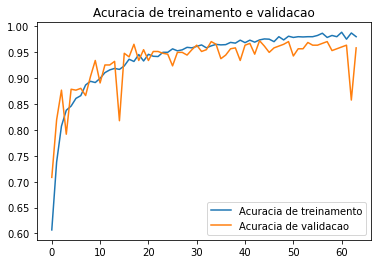

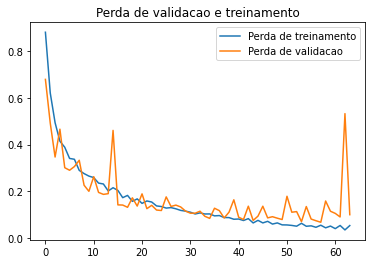

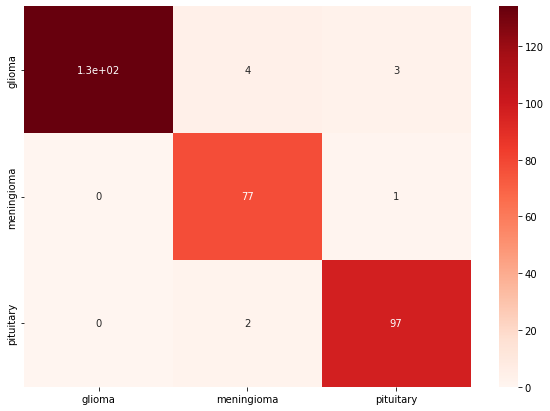

In [11]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Acuracia de treinamento')
plt.plot(epochs, val_acc, label='Acuracia de validacao')
plt.title('Acuracia de treinamento e validacao')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Perda de treinamento')
plt.plot(epochs, val_loss, label='Perda de validacao')
plt.title('Perda de validacao e treinamento')
plt.legend()

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ['glioma', 'meningioma', 'pituitary']],
                  columns = [i for i in ['glioma', 'meningioma', 'pituitary']])
plt.figure(figsize = (10,7))


sn.heatmap(df_cm, annot=True, cmap="Reds")
print('Classification Report')
target_names = ['glioma', 'meningioma', 'pituitary']
print(classification_report(testdata.classes, y_pred, target_names=target_names))

plt.show()